# Multiple time series with VAR models

Vector autoregression (VAR) models are used when two time series $t_1$ and $t_2$ have a bidirectional relationship i.e. $t_1$ is a predictor of $t_2$ and $t_2$ is a predictor of $t_1$.

This is unlike the SARIMAX model where the exogenous variables have an impact on the target, but not vice versa.

$\text{VAR}(p)$ is a generalization of the $\text{AR}(p)$ model to forecast multiple time series.

Recall that for the $\text{AR}(p)$ model, we have:

$$
y_t=C+\phi_1 y_{t-1}+\phi_2 y_{t-2}+\cdots+\phi_p y_{t-p}+\epsilon_t
$$

Simply extending this to two time series with order $p=1$:

$$
\begin{align}

\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
\end{bmatrix}
&=
\begin{bmatrix}
C_1 \\
C_2
\end{bmatrix}
+
\begin{bmatrix}
\phi_{1,1} & \phi_{1,2} \\
\phi_{2,1} & \phi_{2,2}
\end{bmatrix}
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t} \\
\end{bmatrix} \\

y_{1,t}&=C_1+\phi_{1,1} y_{1,t-1}+\phi_{1,2}y_{2,t-1}+\epsilon_{1,t} \\
y_{2,t}&=C_2+\phi_{2,1} y_{1,t-1}+\phi_{2,2}y_{2,t-1}+\epsilon_{2,t}

\end{align}
$$

Generalizing $p$:

$$
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
\end{bmatrix}
=
\begin{bmatrix}
C_1 \\
C_2
\end{bmatrix}
+
\begin{bmatrix}
\phi_{1,1}^1 & \phi_{1,2}^1 \\
\phi_{2,1}^1 & \phi_{2,2}^1
\end{bmatrix}
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
\end{bmatrix}
+
\cdots
+
\begin{bmatrix}
\phi_{1,1}^p & \phi_{1,2}^p \\
\phi_{2,1}^p & \phi_{2,2}^p
\end{bmatrix}
\begin{bmatrix}
y_{1,t-p} \\
y_{2,t-p} \\
\end{bmatrix}
+
\begin{bmatrix}
\epsilon_{1,t} \\
\epsilon_{2,t} \\
\end{bmatrix}
$$

Just like the $\text{AR}(p)$ model, the $\text{VAR}(p)$ model requires each time series to be stationary.

The $\text{VAR}(p)$ is valid iff both series are useful in predicting one another. To determine if this is the case, we apply the *Granger causality* test. It tests if past values of a time series are statistically significant in forecasting another time series.

The Granger causality test tests causality in one direction; i.e. $y_{1,t}$ *Granger-causes* series $y_{2,t}$ is not sufficient proof that $y_{2,t}$ *Granger-causes* $y_{1,t}$.

The null hypothesis: $y_{2,t}$ does not Granger-cause $y_{1,t}$. If the p-value is <0.05 we reject the null hypothesis and conclude that $y_{2,t}$ Granger-causes $y_{1,t}$.

## Modeling Procedure
![](public/10-2.svg)

In [2]:
import pandas as pd
import statsmodels.api as sm

macro_econ_data: pd.DataFrame = sm.datasets.macrodata.load_pandas().data
macro_econ_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


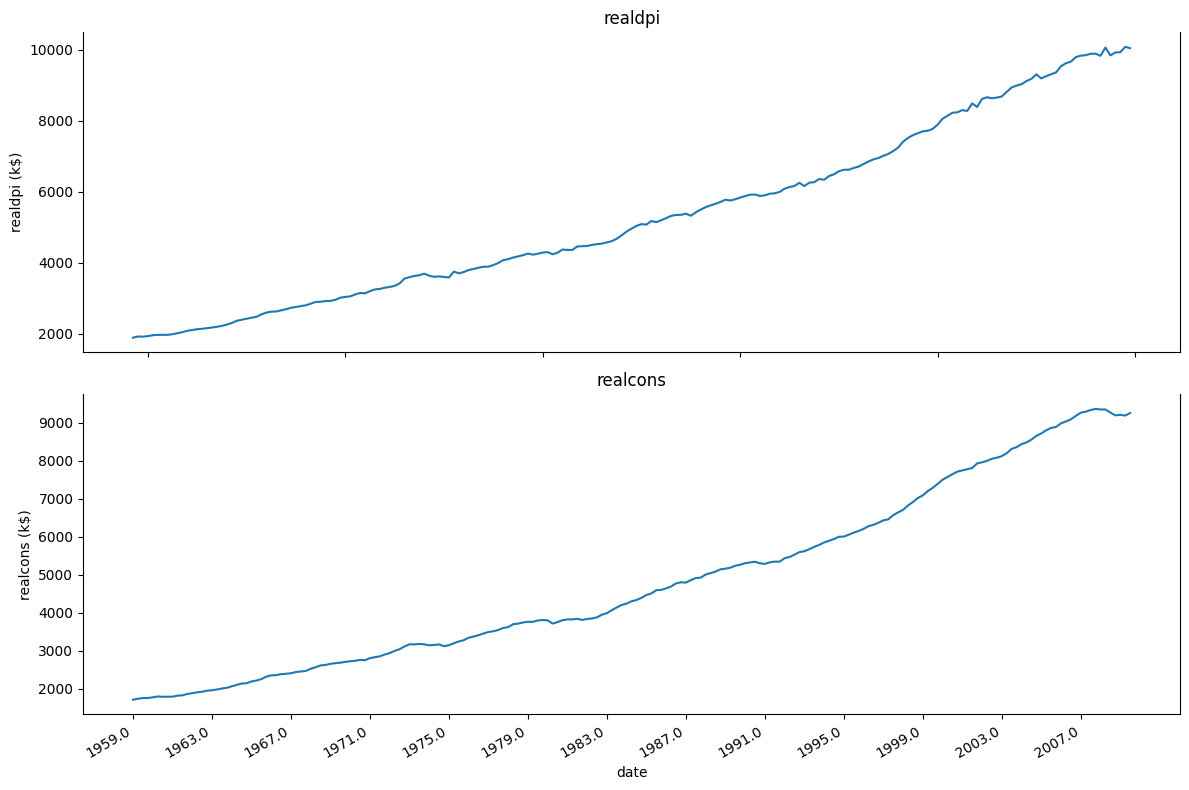

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

xx = macro_econ_data['year'] + .25 * macro_econ_data['quarter']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
ax1: Axes; ax2: Axes

ax1.plot(xx, macro_econ_data['realdpi'])
ax1.set_xlabel('date')
ax1.set_ylabel('realdpi (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(xx, macro_econ_data['realcons'])
ax2.set_xlabel('date')
ax2.set_ylabel('realcons (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(xx[::16], macro_econ_data['year'][::16])

fig.autofmt_xdate()
fig.tight_layout()

In [25]:
from typing import Union
from statsmodels.tsa.stattools import adfuller

def test_stationarity(data: Union[pd.Series, np.ndarray]):
    result = adfuller(data)
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')

In [26]:
test_stationarity(macro_econ_data['realdpi'])
test_stationarity(macro_econ_data['realcons'])

ADF Statistic: 2.986
p-value: 1.000
ADF Statistic: 1.550
p-value: 0.998


In [27]:
test_stationarity(macro_econ_data['realdpi'].diff().dropna())
test_stationarity(macro_econ_data['realcons'].diff().dropna())

ADF Statistic: -8.865
p-value: 0.000
ADF Statistic: -4.204
p-value: 0.001


In [44]:
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(
    endog: pd.Series,
) -> pd.DataFrame:
    results: list[tuple[int, float]] = []
    for i in tqdm(range(1, 8)):
        model = VARMAX(
            endog, 
            order=(i, 0) # (p, q)
        ).fit(disp=False)
        aic = model.aic
        results.append((i, aic))
    result_df = (pd.DataFrame(results, columns=('p', 'AIC'))
                 .sort_values(by='AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

In [45]:
endog = macro_econ_data[['realdpi', 'realcons']]
endog_diff = endog.diff().dropna()

train = endog_diff.iloc[:162]
test = endog_diff.iloc[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/7 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() i

,p,AIC
0,3,3123.070082
1,5,3123.708523
2,6,3126.855596
3,4,3129.194037
4,2,3130.091668
5,7,3133.395639
6,1,3134.333343


In [56]:
from statsmodels.tsa.stattools import grangercausalitytests

def test_granger_causes(
    data: pd.DataFrame,
    p: int,
):
    grangercausalitytests(data, [p])

data = macro_econ_data[['realdpi', 'realcons']].diff().dropna()

print('realcons -Granger causes-> realdpi')
test_granger_causes(data, 3)

print('\nrealdpi -Granger causes-> realcons')
test_granger_causes(data[['realcons', 'realdpi']], 3)

realcons -Granger causes-> realdpi

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi -Granger causes-> realcons

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


realdpi
realcons


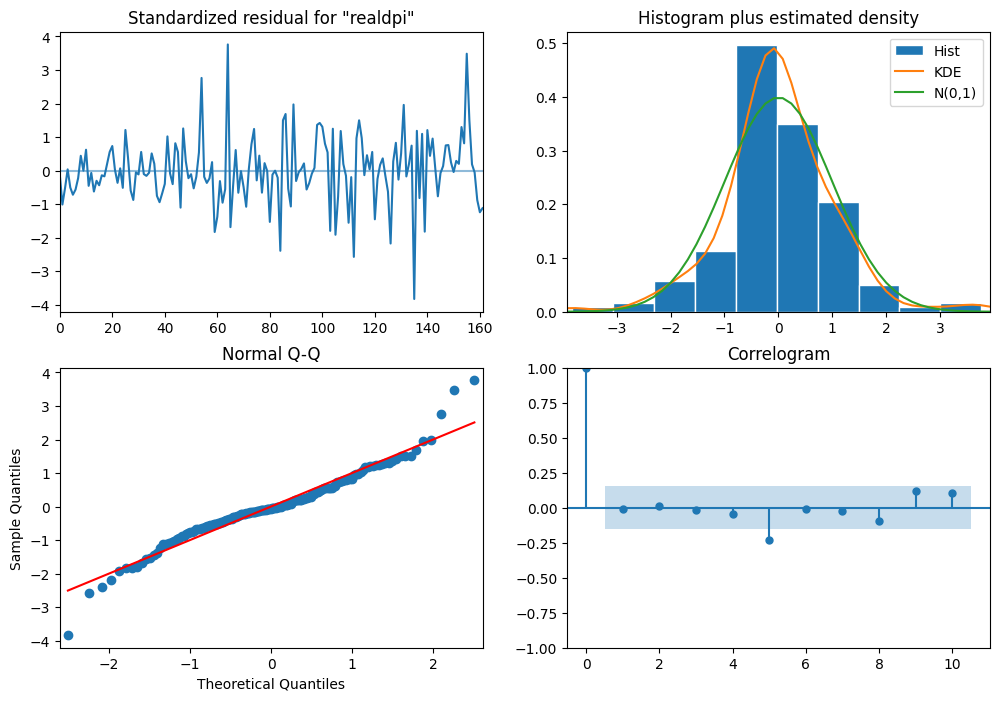

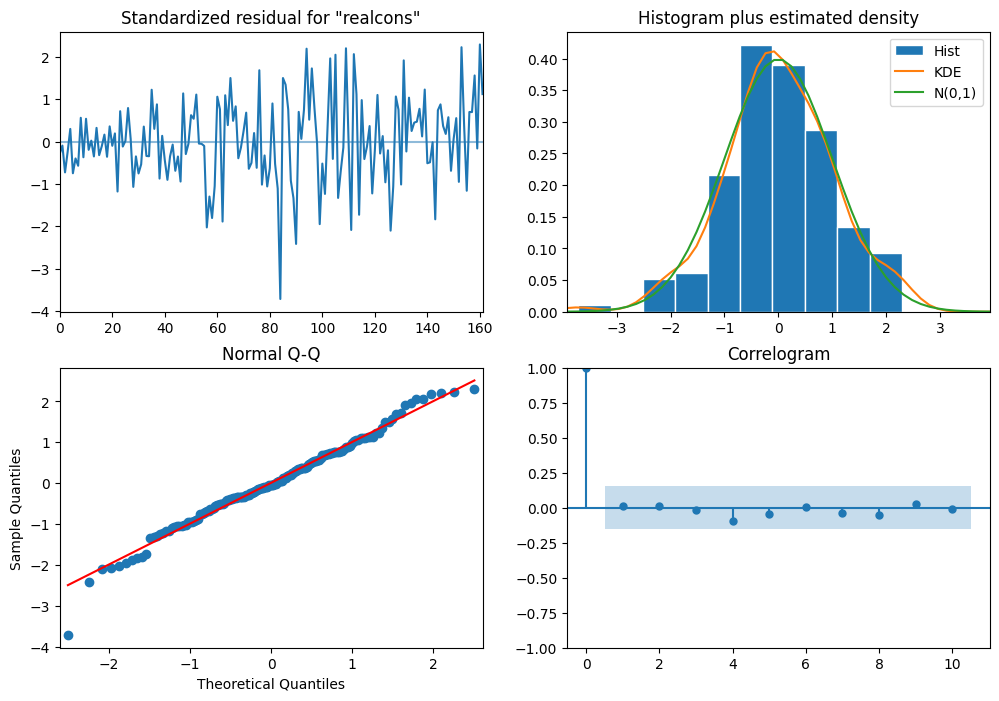

In [58]:
from statsmodels.tsa.statespace.varmax import VARMAXResults

best_model = VARMAX(train, order=(3, 0))
best_model_fit: VARMAXResults = best_model.fit(disp=False)
best_model_fit.plot_diagnostics(figsize=(12,8), variable=0) # realdpi
best_model_fit.plot_diagnostics(figsize=(12,8), variable=1); # realcons

In [64]:
from statsmodels.stats.diagnostic import acorr_ljungbox

def get_varmax_residual_pvalues(residuals: pd.Series):
    lb_df = acorr_ljungbox(residuals, np.arange(1, 11))
    lb_df = (lb_df
             .sort_values(by='lb_pvalue', ascending=True)
             .reset_index(drop=True))
    return lb_df

print('realdpi\n', get_varmax_residual_pvalues(best_model_fit.resid['realdpi']))
print('realcons\n', get_varmax_residual_pvalues(best_model_fit.resid['realcons']))

realdpi
      lb_stat  lb_pvalue
0   9.142521   0.103513
1  15.287331   0.121932
2  13.318077   0.148734
3   9.165356   0.164490
4  10.811544   0.212608
5   9.270104   0.233841
6   0.011638   0.914091
7   0.377929   0.984244
8   0.029397   0.985409
9   0.075824   0.994572
realcons
     lb_stat  lb_pvalue
0  0.023877   0.877198
1  0.068709   0.966229
2  2.150391   0.976051
3  2.437084   0.982528
4  2.442749   0.991684
5  0.787312   0.992410
6  0.235711   0.993577
7  1.015248   0.994579
8  0.068786   0.995300
9  0.377759   0.995920


In [129]:
from typing import Literal
from statsmodels.tsa.statespace.varmax import VARMAXResults
from statsmodels.tsa.statespace.mlemodel import PredictionResults

def rolling_forecast(
    data: pd.DataFrame,
    train_len: int,
    horizon: int,
    window: int,
    method: Literal['VAR', 'last'],
) -> tuple[np.ndarray, np.ndarray]: # (realdpi, realcons)
    assert len(data) == train_len + horizon
    realdpi_pred = np.empty(horizon)
    realcons_pred = np.empty(horizon)
    if method == 'VAR':
        for i in range(0, horizon, window):
            model = VARMAX(data[:train_len+i], order=(3, 0))
            res: VARMAXResults = model.fit(disp=False)
            predictions: PredictionResults = res.get_prediction(0, train_len+i+window-1)
            oos_pred: pd.DataFrame = predictions.predicted_mean.iloc[-window:]
            oos_pred_realdpi = oos_pred['realdpi'].values
            oos_pred_realcons = oos_pred['realcons'].values
            realdpi_pred[i:i+window] = oos_pred_realdpi
            realcons_pred[i:i+window] = oos_pred_realcons
        return realdpi_pred, realcons_pred
    elif method == 'last':
        for i in range(0, horizon, window):
            last = data[:train_len+i].iloc[-1]
            realdpi_pred[i:i+window] = last['realdpi']
            realcons_pred[i:i+window] = last['realcons']
        return realdpi_pred, realcons_pred

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = rolling_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

In [139]:
realdpi_pred_last, realcons_pred_last = rolling_forecast(endog, TRAIN_LEN+1, HORIZON, WINDOW, 'last')

In [ ]:
forecast = endog[163:]
forecast = forecast.assign(realdpi_pred_VAR=(endog.iloc[162]['realdpi'] + 
                                             np.cumsum(realdpi_pred_VAR)),
                           realcons_pred_VAR=(endog.iloc[162]['realcons'] + 
                                              np.cumsum(realcons_pred_VAR)),
                           realdpi_pred_last=realdpi_pred_last,
                           realcons_pred_last=realcons_pred_last)
forecast.head(10)

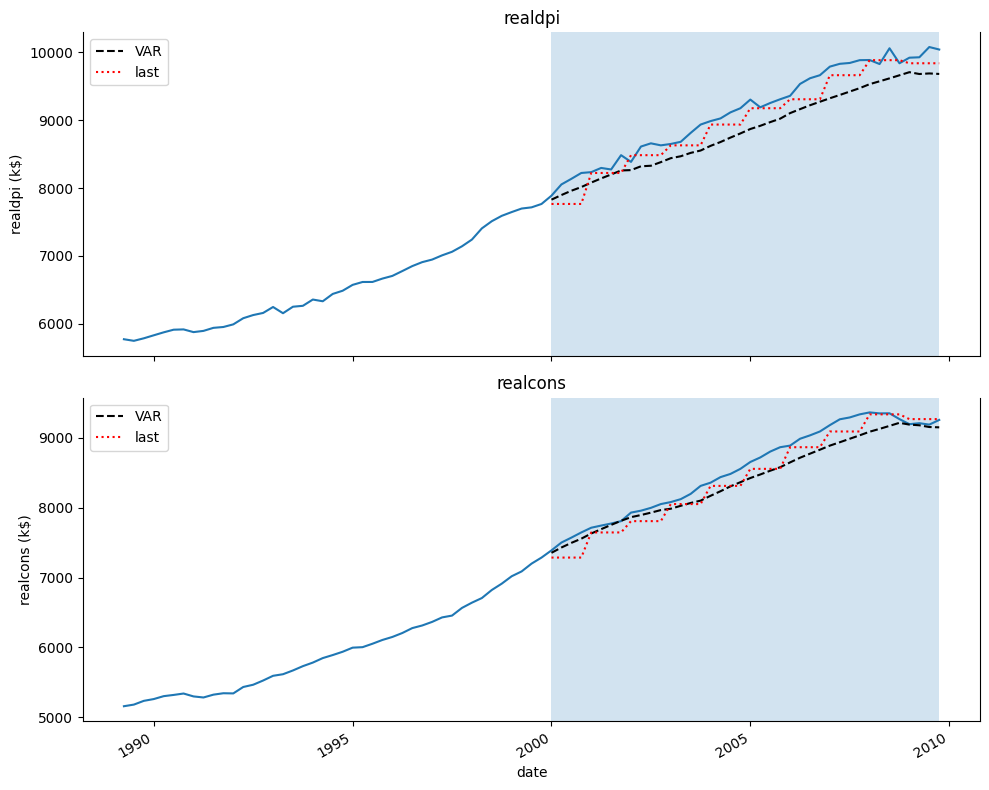

In [141]:
xx = macro_econ_data['year'] + .25 * macro_econ_data['quarter']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
ax1: Axes; ax2: Axes

START = 120

ax1.plot(xx[START:], macro_econ_data['realdpi'][START:])
ax1.set_xlabel('date')
ax1.set_ylabel('realdpi (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(xx[163], xx.iloc[-1], alpha=.2)
ax1.plot(xx[163:], forecast['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(xx[163:], forecast['realdpi_pred_last'], 'r:', label='last')
ax1.legend(loc=2)


ax2.plot(xx[START:], macro_econ_data['realcons'][START:])
ax2.set_xlabel('date')
ax2.set_ylabel('realcons (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(xx[163], xx.iloc[-1], alpha=.2)
ax2.plot(xx[163:], forecast['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(xx[163:], forecast['realcons_pred_last'], 'r:', label='last')
ax2.legend(loc=2)

# plt.xticks(xx[::16], macro_econ_data['year'][::16])

fig.autofmt_xdate()
fig.tight_layout()

In [143]:
from sklearn.metrics import mean_absolute_percentage_error

mape_VAR = mean_absolute_percentage_error(forecast['realdpi'], forecast['realdpi_pred_VAR'])
mape_last = mean_absolute_percentage_error(forecast['realdpi'], forecast['realdpi_pred_last'])

print('realdpi')
print(f'MAPE of last: {100*mape_last:.2f}%')
print(f'MAPE of VAR: {100*mape_VAR:.2f}%')

mape_VAR = mean_absolute_percentage_error(forecast['realcons'], forecast['realcons_pred_VAR'])
mape_last = mean_absolute_percentage_error(forecast['realcons'], forecast['realcons_pred_last'])

print('realcons')
print(f'MAPE of last: {100*mape_last:.2f}%')
print(f'MAPE of VAR: {100*mape_VAR:.2f}%')

realdpi
MAPE of last: 1.71%
MAPE of VAR: 3.14%
realcons
MAPE of last: 1.68%
MAPE of VAR: 1.77%


VAR(3) performs worse than baseline. Hypothesis: although the Granger causality test passed, `realdpi` and `realcons` are not predictive enough. Thus, two separate models, which include `realdpi` and `realcons` as exogenous variables, while potentially including moving average terms ($q\ne 0$).